In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from library import datasets, models
from flax import linen as nn
from jax import random, numpy as jnp
import optax
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
import matplotlib.pyplot as plt

AMBIENT_DIM = 2

2022-11-28 21:25:30.854532: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
/home/trent/anaconda3/envs/python3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
key = random.PRNGKey(5)
key_A, key_B = random.split(key)
A = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_A)
B = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_B)

In [4]:
discriminator_A = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1),
])

discriminator_B = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1),
])

generator_AB = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM),
])

generator_BA = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM),
])

model = models.cyclegan.CycleGAN(
    {
        'generator_AB': generator_AB,
        'generator_BA': generator_BA,
        'discriminator_A': discriminator_A,
        'discriminator_B': discriminator_B,
    },
    (AMBIENT_DIM,), (AMBIENT_DIM,))

print(model)
model.initialize(optax.sigmoid_binary_cross_entropy)


generator_AB:
	Model Structure:
		Sequential(
		    # attributes
		    layers = [Dense(
		        # attributes
		        features = 8
		        use_bias = True
		        dtype = None
		        param_dtype = float32
		        precision = None
		        kernel_init = init
		        bias_init = zeros
		    ), <jax._src.custom_derivatives.custom_jvp object at 0x7f425e293790>, Dense(
		        # attributes
		        features = 8
		        use_bias = True
		        dtype = None
		        param_dtype = float32
		        precision = None
		        kernel_init = init
		        bias_init = zeros
		    ), <jax._src.custom_derivatives.custom_jvp object at 0x7f425e293790>, Dense(
		        # attributes
		        features = 4
		        use_bias = True
		        dtype = None
		        param_dtype = float32
		        precision = None
		        kernel_init = init
		        bias_init = zeros
		    ), <jax._src.custom_derivatives.custom_jvp object at 0x7f425e293790>, Dense(
		        # attributes
		     

In [5]:
gan_AB, gan_BA = model.create_distribution()

In [6]:
real_A = A.get_tensors()
real_B = B.get_tensors()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)
print(fake_A.shape, fake_B.shape, real_A.shape, real_B.shape)

(1000, 2) (1000, 2) (1000, 2) (1000, 2)


In [7]:
df_A = {'x': jnp.concatenate((real_A[:, 0], fake_A[:, 0]), axis=0),
      'y': jnp.concatenate((real_A[:, 1], fake_A[:, 1]), axis=0),
      'labels': jnp.concatenate((jnp.ones((real_A.shape[0],)), jnp.zeros((fake_A.shape[0],))), axis=0)}
px.scatter(df_A, x='x', y='y', color='labels')

In [8]:
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=250, cycle_loss_weight=5)

iteration 0; g_AB_l_g:  6.99e-01 g_AB_l_c:  8.26e-01; g_BA_l_g:  7.24e-01 g_BA_l_c:  7.57e-01; d_A_l:  6.78e-01; d_B_l:  7.20e-01; g_AB_gm:  9.46e-02; g_BA_gm:  5.48e-02; dis_A_gm:  6.76e-03; dis_B_gm:  1.81e-02: : 1it [00:03,  3.54s/it]
iteration 0; g_AB_l_g:  6.94e-01 g_AB_l_c:  8.23e-01; g_BA_l_g:  7.38e-01 g_BA_l_c:  7.07e-01; d_A_l:  6.69e-01; d_B_l:  7.12e-01; g_AB_gm:  9.87e-02; g_BA_gm:  6.22e-02; dis_A_gm:  8.37e-03; dis_B_gm:  1.07e-02: : 1it [00:00,  5.63it/s]
iteration 0; g_AB_l_g:  6.90e-01 g_AB_l_c:  8.19e-01; g_BA_l_g:  7.55e-01 g_BA_l_c:  6.52e-01; d_A_l:  6.59e-01; d_B_l:  7.08e-01; g_AB_gm:  1.04e-01; g_BA_gm:  6.95e-02; dis_A_gm:  8.86e-03; dis_B_gm:  9.73e-03: : 1it [00:00,  5.74it/s]
iteration 0; g_AB_l_g:  6.88e-01 g_AB_l_c:  8.19e-01; g_BA_l_g:  7.76e-01 g_BA_l_c:  5.91e-01; d_A_l:  6.47e-01; d_B_l:  7.04e-01; g_AB_gm:  1.05e-01; g_BA_gm:  7.58e-02; dis_A_gm:  1.03e-02; dis_B_gm:  8.68e-03: : 1it [00:00,  5.73it/s]
iteration 0; g_AB_l_g:  6.87e-01 g_AB_l_c:  8.15

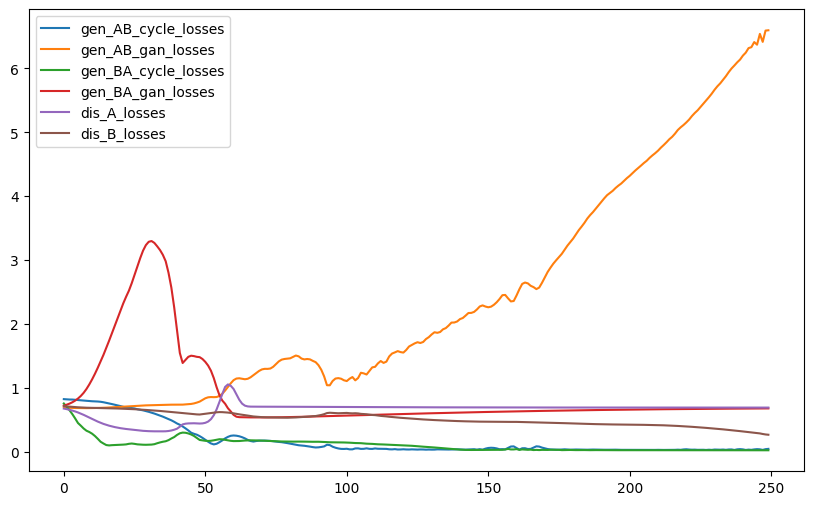

In [9]:
fig = plt.figure(figsize=(10, 6))
for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)
plt.legend()
plt.show()

In [10]:
gan_AB, gan_BA = model.create_distribution()

In [11]:
real_A = A.get_tensors()
real_B = B.get_tensors()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)
print(fake_A.shape, fake_B.shape, real_A.shape, real_B.shape)

(1000, 2) (1000, 2) (1000, 2) (1000, 2)


In [12]:
point_pair_dataset_A = datasets.point_dataset.PointPairDataset(real_A, real_A, fake_A)
point_pair_dataset_B = datasets.point_dataset.PointPairDataset(real_B, real_B, fake_B)

In [13]:
point_pair_dataset_A.create_visualization()

In [14]:
px.scatter(x=jnp.concatenate((real_A[:, 0], fake_A[:, 0]), axis=0), y=jnp.concatenate((
    real_A[:, 1], fake_A[:, 1]), axis=0), color=jnp.concatenate((jnp.ones(real_A.shape[0]), jnp.zeros(fake_A.shape[0])), axis=0))


In [15]:
point_pair_dataset_B.create_visualization()

In [16]:
px.scatter(x=jnp.concatenate((real_B[:, 0], fake_B[:, 0]), axis=0), y=jnp.concatenate((
    real_B[:, 1], fake_B[:, 1]), axis=0), color=jnp.concatenate((jnp.ones(real_B.shape[0]), jnp.zeros(fake_B.shape[0])), axis=0))

In [17]:
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=5)

iteration 0; g_AB_l_g:  6.53e+00 g_AB_l_c:  4.19e-02; g_BA_l_g:  6.81e-01 g_BA_l_c:  2.51e-02; d_A_l:  6.93e-01; d_B_l:  3.54e-01; g_AB_gm:  1.40e-01; g_BA_gm:  4.55e-02; dis_A_gm:  2.09e-04; dis_B_gm:  1.99e-01: : 1it [00:01,  1.06s/it]
iteration 0; g_AB_l_g:  7.06e+00 g_AB_l_c:  1.15e-01; g_BA_l_g:  6.83e-01 g_BA_l_c:  1.03e-01; d_A_l:  6.93e-01; d_B_l:  2.85e-01; g_AB_gm:  2.64e-01; g_BA_gm:  4.95e-01; dis_A_gm:  1.58e-04; dis_B_gm:  6.23e-02: : 1it [00:00,  5.72it/s]
iteration 0; g_AB_l_g:  6.68e+00 g_AB_l_c:  8.57e-02; g_BA_l_g:  6.86e-01 g_BA_l_c:  3.04e-02; d_A_l:  6.93e-01; d_B_l:  2.84e-01; g_AB_gm:  1.57e-01; g_BA_gm:  1.10e-01; dis_A_gm:  1.08e-04; dis_B_gm:  8.77e-02: : 1it [00:00,  5.76it/s]
iteration 0; g_AB_l_g:  6.33e+00 g_AB_l_c:  7.68e-02; g_BA_l_g:  6.88e-01 g_BA_l_c:  4.93e-02; d_A_l:  6.93e-01; d_B_l:  3.10e-01; g_AB_gm:  2.52e-01; g_BA_gm:  2.51e-01; dis_A_gm:  6.07e-05; dis_B_gm:  1.37e-01: : 1it [00:00,  5.81it/s]
iteration 0; g_AB_l_g:  6.22e+00 g_AB_l_c:  4.81

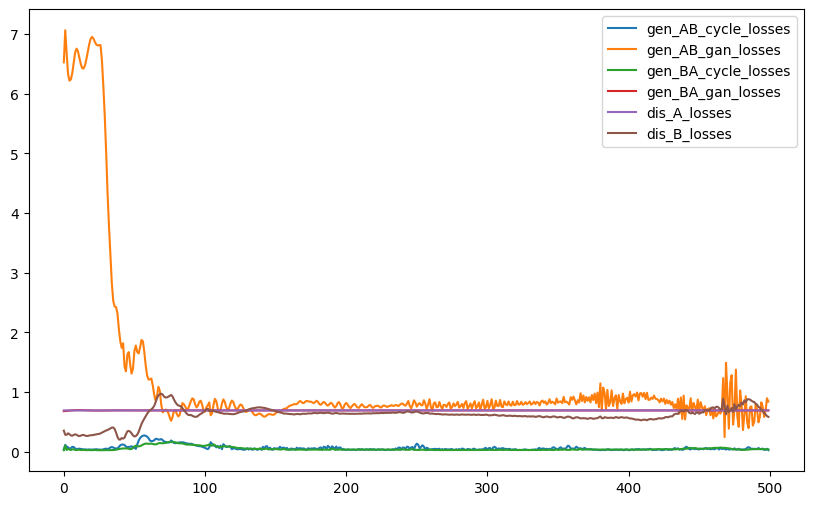

In [18]:
fig = plt.figure(figsize=(10, 6))
for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)
plt.legend()
plt.show()

In [19]:
gan_AB, gan_BA = model.create_distribution()

In [20]:
real_A = A.get_tensors()
real_B = B.get_tensors()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)
print(fake_A.shape, fake_B.shape, real_A.shape, real_B.shape)

(1000, 2) (1000, 2) (1000, 2) (1000, 2)


In [21]:
point_pair_dataset_A = datasets.point_dataset.PointPairDataset(real_A, real_A, fake_A)
point_pair_dataset_B = datasets.point_dataset.PointPairDataset(real_B, real_B, fake_B)

In [22]:
point_pair_dataset_A.create_visualization()

In [23]:
px.scatter(x=jnp.concatenate((real_A[:, 0], fake_A[:, 0]), axis=0), y=jnp.concatenate((
    real_A[:, 1], fake_A[:, 1]), axis=0), color=jnp.concatenate((jnp.ones(real_A.shape[0]), jnp.zeros(fake_A.shape[0])), axis=0))


In [24]:
point_pair_dataset_B.create_visualization()

In [25]:
px.scatter(x=jnp.concatenate((real_B[:, 0], fake_B[:, 0]), axis=0), y=jnp.concatenate((
    real_B[:, 1], fake_B[:, 1]), axis=0), color=jnp.concatenate((jnp.ones(real_B.shape[0]), jnp.zeros(fake_B.shape[0])), axis=0))

In [26]:
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=5)

iteration 0; g_AB_l_g:  6.89e-01 g_AB_l_c:  6.00e-02; g_BA_l_g:  6.93e-01 g_BA_l_c:  3.91e-02; d_A_l:  6.93e-01; d_B_l:  1.48e+00; g_AB_gm:  5.99e-01; g_BA_gm:  2.79e-01; dis_A_gm:  5.39e-06; dis_B_gm:  1.80e+00: : 1it [00:01,  1.11s/it]
iteration 0; g_AB_l_g:  3.55e+00 g_AB_l_c:  3.19e-01; g_BA_l_g:  6.93e-01 g_BA_l_c:  4.66e-02; d_A_l:  6.93e-01; d_B_l:  6.26e-01; g_AB_gm:  4.17e-01; g_BA_gm:  1.54e-01; dis_A_gm:  3.31e-05; dis_B_gm:  9.76e-01: : 1it [00:00,  5.34it/s]
iteration 0; g_AB_l_g:  1.97e+00 g_AB_l_c:  3.50e-01; g_BA_l_g:  6.95e-01 g_BA_l_c:  5.61e-02; d_A_l:  6.93e-01; d_B_l:  5.63e-01; g_AB_gm:  1.26e+00; g_BA_gm:  2.51e-01; dis_A_gm:  5.26e-06; dis_B_gm:  7.94e-01: : 1it [00:00,  5.49it/s]
iteration 0; g_AB_l_g:  2.71e-01 g_AB_l_c:  2.57e-01; g_BA_l_g:  6.93e-01 g_BA_l_c:  4.38e-02; d_A_l:  6.93e-01; d_B_l:  9.35e-01; g_AB_gm:  6.19e-01; g_BA_gm:  1.61e-01; dis_A_gm:  2.19e-05; dis_B_gm:  1.26e+00: : 1it [00:00,  5.39it/s]
iteration 0; g_AB_l_g:  8.95e-02 g_AB_l_c:  1.48

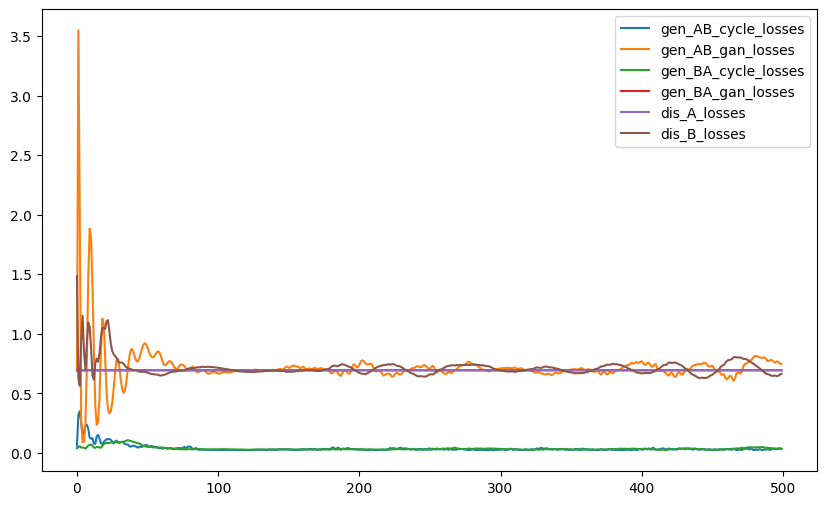

In [27]:
fig = plt.figure(figsize=(10, 6))
for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)
plt.legend()
plt.show()

In [28]:
gan_AB, gan_BA = model.create_distribution()

In [29]:
real_A = A.get_tensors()
real_B = B.get_tensors()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)
print(fake_A.shape, fake_B.shape, real_A.shape, real_B.shape)

(1000, 2) (1000, 2) (1000, 2) (1000, 2)


In [30]:
point_pair_dataset_A = datasets.point_dataset.PointPairDataset(real_A, real_A, fake_A)
point_pair_dataset_B = datasets.point_dataset.PointPairDataset(real_B, real_B, fake_B)

In [31]:
point_pair_dataset_A.create_visualization()

In [32]:
px.scatter(x=jnp.concatenate((real_A[:, 0], fake_A[:, 0]), axis=0), y=jnp.concatenate((
    real_A[:, 1], fake_A[:, 1]), axis=0), color=jnp.concatenate((jnp.ones(real_A.shape[0]), jnp.zeros(fake_A.shape[0])), axis=0))


In [33]:
point_pair_dataset_B.create_visualization()

In [34]:
px.scatter(x=jnp.concatenate((real_B[:, 0], fake_B[:, 0]), axis=0), y=jnp.concatenate((
    real_B[:, 1], fake_B[:, 1]), axis=0), color=jnp.concatenate((jnp.ones(real_B.shape[0]), jnp.zeros(fake_B.shape[0])), axis=0))